# Multimodal Search with Nova Embeddings

This notebook demonstrates how to build a multimodal search system using AWS Nova embeddings in Weaviate, enabling image search, hybrid search, and the Weaviate Query Agent.


At the time of writing this notebook, we're using:
* `weaviate-client` == `4.18.0`
* `weaviate database` == `1.34.0`
* `weaviate-agents` == `1.1.0`

## Install Dependencies and Libraries

In [ ]:
!pip install weaviate-client --q

In [ ]:
!pip install weaviate-agents --q

In [ ]:
!pip install pillow --q

In [1]:
import os
import weaviate
from weaviate.classes.init import Auth
from weaviate.classes.config import Property, DataType, Configure, Multi2VecField
from weaviate.agents.query import QueryAgent

import base64
from io import BytesIO
from PIL import Image
from IPython.display import display
from pathlib import Path

## Connect to Weaviate

You can create a free 14-day sandbox on [Weaviate Cloud](https://console.weaviate.cloud)!

In [ ]:
WCD_URL = os.environ.get("WEAVIATE_URL")  # Replace with your Weaviate cluster URL
WCD_AUTH_KEY = os.environ.get("WEAVIATE_AUTH")  # Replace with your cluster auth key
AWS_ACCESS_KEY = os.environ.get("AWS_ACCESS_KEY")  # Replace with your access key 
AWS_SECRET_KEY = os.environ.get("AWS_SECRET_KEY")  # Replace with your secret key 


# Weaviate Cloud Deployment
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=WCD_URL,
    auth_credentials=weaviate.auth.AuthApiKey(WCD_AUTH_KEY),
    headers = {
    "X-AWS-Access-Key": AWS_ACCESS_KEY,
    "X-AWS-Secret-Key": AWS_SECRET_KEY,
    }
)

print(client.is_ready())

True


## Create Collection

In [ ]:
collection_name = "Memes"

# Delete the collection if it already exists
if (client.collections.exists(collection_name)):
    client.collections.delete(collection_name)

client.collections.create(
    "Memes",
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="image", data_type=DataType.BLOB),
    ],
    vector_config=[
    Configure.Vectors.multi2vec_aws(
        name="title_vector",
        # Define the fields to be used for the vectorization - using image_fields and text_fields
        image_fields=[
            Multi2VecField(name="image", weight=0.9)
        ],
        text_fields=[
            Multi2VecField(name="title", weight=0.1)
    ],
    model="amazon.nova-2-multimodal-embeddings-v1:0",
    region= "us-east-1"
    )],
    generative_config=Configure.Generative.aws(
        service="bedrock", 
        model="amazon.nova-lite-v1:0", 
        region= "us-east-1")
)

## Grab Data

### Convert Images into Base64

In [19]:
image_folder = "./images"

image_files = [
    f for f in os.listdir(image_folder)
    if f.lower().endswith(".jpeg")
]

# Store image data as a list of dicts
image_data = []

for file_name in image_files:
    file_path = os.path.join(image_folder, file_name)
    with open(file_path, "rb") as image_file:
        # Convert image to base64 string
        base64_str = base64.b64encode(image_file.read()).decode("utf-8")
        # Remove extension for title if you prefer
        title = os.path.splitext(file_name)[0]
        image_data.append({
            "title": title,
            "image_base64": base64_str
        })

### Ingest Data into Weaviate

In [36]:
collection = client.collections.use("Memes")

with collection.batch.fixed_size(batch_size=10) as batch:
    for item in image_data:
        weaviate_obj = {
            "title": item["title"],
            "image": item["image_base64"]
        }

        batch.add_object(
            properties=weaviate_obj,
        )

## Query Time

### Image Search
We can use the `near_image` operator to search for images in our local path.

Title: monkey-side-eye


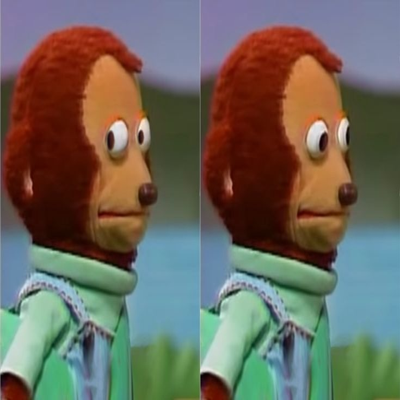

In [5]:
memes = client.collections.use("Memes")

response = memes.query.near_image(
    near_image=Path("./images/monkey-side-eye.jpeg"),
    return_properties=["title", "image"],
    limit=1
)

for o in response.objects:
    props = o.properties
    print("Title:", props.get("title"))
    image_b64 = props.get("image")
    image_bytes = base64.b64decode(image_b64)
    image = Image.open(BytesIO(image_bytes))
    image = image.resize((400, 400)) 
    display(image)

### Hybrid Search on the Title Property

The `hybrid` operator uses vector and keyword search together and is weighted depending on the `alpha` parameter.

* `alpha` = 0 -> pure keyword search
* `alpha` = 1 -> pure vector search
* `alpha` = 0.5 -> equal weighting of the two search algorithms

Title: spiderman


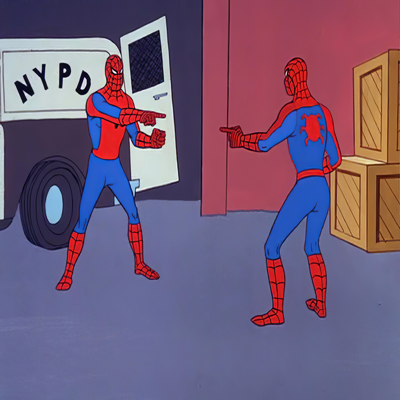

In [4]:
memes = client.collections.use("Memes")
response = memes.query.hybrid(
    query="spiderman", 
    alpha=0.75,
    return_properties=["title", "image"],
    limit=1
)

for o in response.objects:
    props = o.properties
    print("Title:", props.get("title"))
    image_b64 = props.get("image")
    image_bytes = base64.b64decode(image_b64)
    image = Image.open(BytesIO(image_bytes))
    image = image.resize((400, 400)) 
    display(image)

### Query Agent

We can pass in images to the [Query Agent](https://docs.weaviate.io/agents/query/usage) to answer natural language queries based on our images. 

For example, below we're asking, "Which meme should I use to explain that two things are similar?", and it is searching through our database to find relevant images. 

In [ ]:
qa = QueryAgent(
    client=client,
    collections=["Memes"]
)

response = qa.ask("Which meme should I use to explain that two things are similar?")

response.display()

╭───────────────────────────────────────────── 💬 Ask Mode Response ──────────────────────────────────────────────╮
│                                                                                                                 │
│ To explain that two things are similar, the Spider-Man pointing meme is a great choice. It humorously depicts   │
│ two identical Spider-Man characters pointing at each other, symbolizing likeness or equivalence between two     │
│ subjects. This effectively conveys the idea that both things are essentially the same or have strong            │
│ similarities. This meme is clear, recognizable, and widely used for comparisons.                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🔭 Search 1/3 ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ QueryResultWithCollectionNormalized(                                                                            │
│     query='meme similarities two things same similar comparison',                                               │
│     filters=None,                                                                                               │
│     collection='Memes',                                                                                         │
│     sort_property=None                                                                                          │
│ )                                                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🔭 Search 2/3 ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ QueryResultWithCollectionNormalized(                                                                            │
│     query='meme about comparison similarity two things alike',                                                  │
│     filters=None,                                                                                               │
│     collection='Memes',                                                                                         │
│     sort_property=None                                                                                          │
│ )                                                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🔭 Search 3/3 ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ QueryResultWithCollectionNormalized(                                                                            │
│     query='meme expressing similarity likeness equivalence comparison two things same similar',                 │
│     filters=None,                                                                                               │
│     collection='Memes',                                                                                         │
│     sort_property=None                                                                                          │
│ )                                                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 📊 No Aggregations Run                                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── 📚 Sources ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  - object_id='7454aa0e-5088-4c48-8a02-9bd1c0d83cb3' collection='Memes'                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

        📊 Usage Statistics        
┌──────────────────────────┬──────┐
│ Model Units:             │ 450  │
│ Usage in Plan:           │ True │
│ Remaining Plan Requests: │ -1   │
└──────────────────────────┴──────┘

Total Time Taken: 10.82s

In [13]:
response = qa.ask("Can you describe some of the memes in my database?")

response.display()

╭───────────────────────────────────────────── 💬 Ask Mode Response ──────────────────────────────────────────────╮
│                                                                                                                 │
│ Your database contains the following memes:                                                                     │
│                                                                                                                 │
│ 1. **Hide**: This meme features Homer Simpson slowly retreating into a bush and eventually disappearing into    │
│ it. It's often used to express moments when someone wants to quietly back away or avoid a situation.            │
│                                                                                                                 │
│ 2. **Crying Cat**: This meme shows a close-up of a cat with teary eyes and a raised thumb, conveying a mix of   │
│ sadness and approval or encouragement, often used to ironically display emotional support.                      │
│                                                                                                                 │
│ 3. **Monkey Side-Eye**: This meme depicts a puppet monkey glancing sideways with a concerned or suspicious      │
│ expression. It's commonly used to convey awkwardness, disbelief, or side-eyeing a dubious statement or          │
│ situation.                                                                                                      │
│                                                                                                                 │
│ 4. **Fire Meme**: Shows a young girl smirking at the camera while a house burns in the background, suggesting a │
│ mischievous or unapologetic indifference to chaos or disaster around her.                                       │
│                                                                                                                 │
│ 5. **Arthur Fist**: This meme captures a clenched fist from the animated character Arthur, symbolizing          │
│ suppressed anger or frustration.                                                                                │
│                                                                                                                 │
│ These memes represent various emotions and reactions, often used humorously to depict awkwardness, subtle       │
│ judgment, or emotional moments.                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🔭 Search 1/1 ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ QueryResultWithCollectionNormalized(                                                                            │
│     query='describe meme title meaning template origin usage joke cultural impact context meme explanation',    │
│     filters=None,                                                                                               │
│     collection='Memes',                                                                                         │
│     sort_property=None                                                                                          │
│ )                                                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 📊 No Aggregations Run                                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── 📚 Sources ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  - object_id='b5cfd327-4267-4903-9cd4-3ad94c75bca2' collection='Memes'                                          │
│  - object_id='7ed13919-ff28-4f0c-bdee-5f91d99565c2' collection='Memes'                                          │
│  - object_id='8c382bb3-dc7b-461b-b546-8d1cf9e12f6c' collection='Memes'                                          │
│  - object_id='826c6012-7aa0-4102-8e5d-9b463d1d1383' collection='Memes'                                          │
│  - object_id='59eeb28f-a496-4cc6-95e5-115df844fb97' collection='Memes'                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

        📊 Usage Statistics        
┌──────────────────────────┬──────┐
│ Model Units:             │ 204  │
│ Usage in Plan:           │ True │
│ Remaining Plan Requests: │ -1   │
└──────────────────────────┴──────┘

Total Time Taken: 9.72s